
1. Simulate some panel data. We’ll do some analysis similar to the Eclipse Bug Report paper, https://arxiv.org/pdf/1803.04129.pdf, but without the DID piece. Specifically,
  * Simulate N units over T discrete time steps.
  * Add confounding through a variable Z  between treated and untreated units which is constant over time. That is, $Z = Z_i$, and not $Z_{it}$ (where $i$ is an index that runs over units, and $t$ runs over time steps). In particular ...
  * Add a time-varying causal state where $D^*$ (as we defined it in class) is caused by $Z_i$. It should be a binary treatment which turns on and stays on for each test unit ($D^* = 1$) at a different time, but never turns on for control units ($D^* = 0$)
  * Compute counterfactuals $Y^0_{it}$ and $Y^1_{it}$ which are caused by $Z_i$.
2. Use your counterfactuals to estimate the time series causal effect. Plot it, and explain from the data generating process why it's correct.
3. Create a propensity score model for $D*$.
4. Match units to estimate the ATT.
5. Estimate the expected counterfactuals for the test group: $E[Y^1_t |D=1]$ and $E[Y^0_t |D=1]$. You’ll have to be careful: since all the units treatments don’t turn on at the same time, you’ll want to mask out the treatment units in the $D_{it}=0$ state when you’re taking your averages. Numpy’s masked array object can be useful here, numpy.ma.array
6. Use the time series you estimated in (4) to estimate the time-varying ATT.


In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt

Question 1

In [2]:
units = 5000 #N
time_steps = 52 #T

p_z = .5
z = np.random.binomial(1, p_z, size=units) #Z

p_d = .25 + z / 2
d = np.random.binomial(1, p_d, size=units) #Causal state

start = np.random.randint(1, 52, size=units) #Start time for causal state
delta = 5 #Treatment effect

#N x T array of causal state over time D_it which stays on for treatment and never activates for control
d_it = np.array([[0] * (start[index]) + [delta] * (52 - start[index]) for index, treatment in enumerate(d)])

# taken from matrix_completion.ipynb
a_trend = np.arange(0, time_steps, 1)
individual_effects = np.random.normal(size=units)
A_trend = np.tile(a_trend, units).reshape(units, time_steps)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_trend + A_indiv #Y_0

Y_1 = A_trend + A_indiv + d_it #Y_1

Y = [Y_0[i] if d[i] == 0 else Y_1[i] for i in range(len(d))] #Y_0 if d == 0 ow Y_1

df = pd.DataFrame(Y)
df['d'] = d
df['Z'] = z
df['start'] = start

Question 2

How am I measuring the potential outcomes?  
Average y_it at each time step, I suppose  

In [3]:
df_y0 = pd.DataFrame(Y_0)
df_y1 = pd.DataFrame(Y_1)

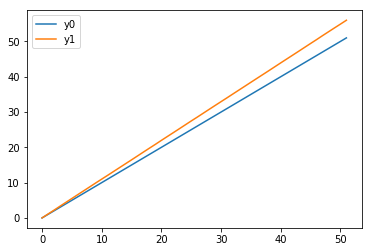

In [4]:
pd.DataFrame({'y0': df_y0.mean(), 'y1': df_y1.mean()}).plot()

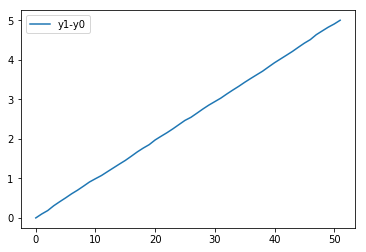

In [5]:
pd.DataFrame({'y1-y0': df_y1.mean() - df_y0.mean()}).plot()

At time $T=52$ the difference in $Y_1$ and $Y_0$ is given by:

In [6]:
df_y1.mean()[51] - df_y0.mean()[51]

4.9999999999998934

The data generating process adds a constant delta = 5 to the treatment group, beginning at a variable start time and continuing until T = 52. As expected the difference in the potential outcomes $Y_0, Y_1$ after T time steps is equal to that delta.

Question 3

In [7]:
from statsmodels.api import WLS, OLS
from sklearn.linear_model import LogisticRegression

In [8]:
var_list = [i for i in range(51)]

In [9]:
propensity_model = LogisticRegression(C=1e12)
propensity_model = propensity_model.fit(df[var_list], df['d'])
df['P_d1_t'] = propensity_model.predict_proba(df[var_list])[:, 1]

Question 4

$w_{i, ATT} = \frac{p_i}{1 - p_i}$ if $d_i = 0$, 1 if $d_i = 1$

In [10]:
df['wATT'] = (df['d'] == 1) * 1 + (df['d'] == 0) * df['P_d1_t'] / (1 - df['P_d1_t'])

coef_d = ATT = 4.74?

In [11]:
df['intercept'] = 1
model = WLS(df[51], df[['d', 'intercept']], weights=df['wATT'])
result = model.fit(cov_type='HC3')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     51   R-squared:                       0.408
Model:                            WLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                 2.240e+04
Date:                Sat, 08 Dec 2018   Prob (F-statistic):               0.00
Time:                        17:40:56   Log-Likelihood:                -12375.
No. Observations:                5000   AIC:                         2.475e+04
Df Residuals:                    4998   BIC:                         2.477e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d              4.9158      0.033    149.676      0.000       4.851       4.980
intercept     51.1004      0.017   3045.706      0.000      51.068      51.133
==============================================================================
Omnibus:                      846.683   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18025.089
Skew:                           0.057   Prob(JB):                         0.00
Kurtosis:                      12.301   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Question 5

Estimate the expected counterfactuals for the test group: 𝐸[𝑌1𝑡|𝐷=1] and 𝐸[𝑌0𝑡|𝐷=1]. You’ll have to be careful: since all the units treatments don’t turn on at the same time, you’ll want to mask out the treatment units in the 𝐷𝑖𝑡=0 state when you’re taking your averages. Numpy’s masked array object can be useful here, numpy.ma.array

Y_1_est contains the measurement of the treatment, $Y | D = 1$  
d_it_1 contains the causal states of the treatment, $d_{it} | D=1$  
Y_1_est_ma is Y_1_est with $Y^1$ values masked, $Y^1 | D = 1$

In [84]:
Y_1_est = [Y[i] for i in range(len(d)) if d[i] == 1]
d_it_1 = [d_it[i] for i in range(len(d)) if d[i] == 1]
d_it_1_trt = [(1 - d_it[i] / 5) for i in range(len(d)) if d[i] == 1] #After d turns on, d_it = 5
Y_1_est_ma = ma.array(Y_1_est, mask=d_it_1)
Y_1_est_trt = ma.array(Y_1_est, mask=d_it_1_trt)

In [85]:
df_ctrl = pd.DataFrame(Y_1_est_ma)
df_trt = pd.DataFrame(Y_1_est_trt)

$E[Y^1|D = 1]$

In [87]:
df_trt.mean()

0           NaN
1      6.140600
2      7.262559
3      8.322479
4      9.152482
5     10.121361
6     11.122153
7     12.160709
8     13.118052
9     14.077070
10    15.060739
11    16.048089
12    17.121004
13    18.109570
14    19.094492
15    20.071266
16    21.067770
17    22.070229
18    23.061829
19    24.049496
20    25.031966
21    26.030986
22    27.035259
23    28.036707
24    29.023536
25    30.028309
26    31.023931
27    32.024601
28    33.026805
29    34.032044
30    35.027149
31    36.020762
32    37.021633
33    38.010110
34    39.012713
35    40.015733
36    41.018236
37    42.012425
38    43.002857
39    44.003576
40    45.000124
41    46.000353
42    47.002939
43    47.996891
44    49.000867
45    50.002911
46    50.994369
47    52.008333
48    53.011718
49    54.013947
50    55.013567
51    56.016221
dtype: float64

$E[Y^0|D = 1]$

In [70]:
df_ctrl.mean()

0      0.016221
1      1.014052
2      2.008335
3      3.001825
4      4.006574
5      5.006159
6      6.004076
7      6.996366
8      8.000037
9      9.004702
10    10.006798
11    11.008697
12    11.987852
13    12.987399
14    13.989012
15    14.994902
16    15.994343
17    16.991748
18    17.993529
19    18.998481
20    20.006885
21    21.006545
22    22.002366
23    23.000019
24    24.009918
25    25.004954
26    26.008499
27    27.007232
28    28.003940
29    28.996283
30    30.001554
31    31.009593
32    32.007376
33    33.027009
34    34.022756
35    35.017229
36    36.011673
37    37.025752
38    38.053541
39    39.057551
40    40.074257
41    41.077492
42    42.074934
43    43.115885
44    44.108965
45    45.112339
46    46.200283
47    47.101246
48    48.081554
49    49.069680
50    50.118456
51          NaN
dtype: float64

Question 6

In [88]:
ATT_est = df_trt.mean() - df_ctrl.mean()

In [90]:
ATT_est[50]

4.8951108891606054

The estimation isn't very far off, but is something happening over time?

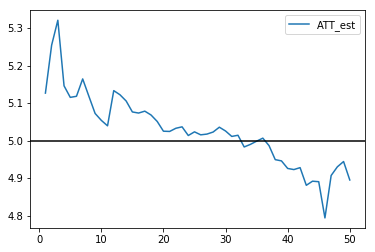

In [96]:
g = pd.DataFrame({'ATT_est': ATT_est}).plot()
g.axhline(y=5, color='black')

In [91]:
ATT_est

0          NaN
1     5.126548
2     5.254224
3     5.320654
4     5.145909
5     5.115202
6     5.118076
7     5.164343
8     5.118015
9     5.072368
10    5.053941
11    5.039392
12    5.133152
13    5.122171
14    5.105481
15    5.076364
16    5.073427
17    5.078481
18    5.068299
19    5.051016
20    5.025080
21    5.024441
22    5.032893
23    5.036689
24    5.013618
25    5.023355
26    5.015431
27    5.017369
28    5.022865
29    5.035760
30    5.025594
31    5.011170
32    5.014257
33    4.983101
34    4.989957
35    4.998504
36    5.006563
37    4.986673
38    4.949316
39    4.946025
40    4.925867
41    4.922861
42    4.928005
43    4.881006
44    4.891902
45    4.890572
46    4.794086
47    4.907088
48    4.930164
49    4.944266
50    4.895111
51         NaN
dtype: float64

Removed trend effects

In [53]:
units = 5000 #N
time_steps = 52 #T

p_z = .5
z = np.random.binomial(1, p_z, size=units) #Z

p_d = .25 + z / 2
d = np.random.binomial(1, p_d, size=units) #Causal state

start = np.random.randint(1, 52, size=units) #Start time for causal state
delta = 5 #Treatment effect

#N x T array of causal state over time D_it which stays on for treatment and never activates for control
d_it = np.array([[0] * (start[index]) + [delta] * (52 - start[index]) for index, treatment in enumerate(d)])

# taken from matrix_completion.ipynb
# but removed trend effects
a_trend = np.arange(0, time_steps, 1)
individual_effects = np.random.normal(size=units)
A_indiv = np.tile(individual_effects, time_steps).reshape(time_steps, units).T
Y_0 = A_indiv #Y_0

Y_1 = A_indiv + d_it #Y_1

Y = [Y_0[i] if d[i] == 0 else Y_1[i] for i in range(len(d))] #Y_0 if d == 0 ow Y_1

df = pd.DataFrame(Y)
df['d'] = d
df['Z'] = z
df['start'] = start